In [1]:
import sys
import pandas as pd
from datetime import datetime, timedelta
sys.path.insert(1, 'D:\Dropbox\FYY\Trading\Projects')
from Dados.Pre.Curva_Pre import CurvaPre
from calendars import DayCounts
import numpy as np
from scipy import interpolate
import datetime
from dateutil.relativedelta import relativedelta
from tqdm import tqdm
%matplotlib inline

In [2]:
C = CurvaPre()

In [3]:
C.read_pre()
C.read_cdi_selic()

In [4]:
prod = pd.read_excel(r'D:\Dropbox\FYY\Trading\Projects\Dados\Pre\TESTE\PRD.xlsx', skiprows=1)

In [5]:
prod = prod[['vertice', 'Dif']]

In [6]:
prod.head()

,vertice,Dif
0,0,0.037862
1,21,0.106702
2,42,-0.557955
3,63,-0.623808
4,84,-0.827379


In [7]:
start_dt = pd.to_datetime('2017-07-03')
n_bdays = prod['vertice']

In [8]:
prod['Pre'], prod['ft_pre'] = C.get_pre_tenor(dt_ref=start_dt, n_bdays=n_bdays)
prod['dv_unit'] = (1.0 / (prod['Pre'] + 1.0 + 1.0 / 10000.0) ** (prod['vertice'] / 252.0)) - (1.0 / prod['ft_pre'])
prod['DV'] = prod['Dif'] * 1000.0
prod['VF'] = prod['DV'] / prod['dv_unit']
prod['VP'] = prod['VF'] / prod['ft_pre']
prod = prod.drop(index=0)
dc_calendar = DayCounts(dc='BUS/252', calendar='anbima')
prod['vcto'] = dc_calendar.workday(start_dt, prod['vertice'])

In [9]:
prod.head()

,vertice,Dif,Pre,ft_pre,dv_unit,DV,VF,VP,vcto
1,21,0.106702,0.100209,1.007990,-0.000008,106.701905,-1.420059e+07,-1.408803e+07,2017-08-01
2,42,-0.557955,0.096451,1.015465,-0.000015,-557.955238,3.727586e+07,3.670818e+07,2017-08-30
3,63,-0.623808,0.093491,1.022595,-0.000022,-623.808095,2.790325e+07,2.728670e+07,2017-09-29
4,84,-0.827379,0.091472,1.029606,-0.000030,-827.379048,2.789561e+07,2.709349e+07,2017-10-31
5,105,0.341895,0.089850,1.036500,-0.000037,341.894762,-9.269751e+06,-8.943317e+06,2017-12-01


In [10]:
df_dv = prod[['vcto','DV']]

In [11]:
df_dv.head()

,vcto,DV
1,2017-08-01,106.701905
2,2017-08-30,-557.955238
3,2017-09-29,-623.808095
4,2017-10-31,-827.379048
5,2017-12-01,341.894762


In [12]:
def divide_robust(n1, n2, error=0):
    lst_n1 = list(n1)
    lst_n2 = list(n2)
    result = []
    assert len(n1) == len(n2), 'Inputs should have same lenght. Check inputs.'
    for x1, x2 in zip(lst_n1, lst_n2):
        try:
            y = x1 / x2
        except:
            y = error
        result.append(y)
    return np.array(result)

In [13]:
df_volume = C.curve.loc[start_dt][['BDAYS', 'TRADING_VOLUME','SETTLE_RATE', 'DT_EXPIRY_BUS']]
df_volume = df_volume.copy(deep=True)
df_volume['DV_u'] = 100000.0 / (1.0 + df_volume['SETTLE_RATE'] / 100.0) ** (df_volume['BDAYS'] / 252) - 100000.0 / (1.0001 + df_volume['SETTLE_RATE'] / 100.0) ** (df_volume['BDAYS'] / 252)
df_volume['DV_traded'] = df_volume['TRADING_VOLUME'] * df_volume['DV_u']
df_volume['M'] = [x.month for x in df_volume['DT_EXPIRY_BUS']]

In [14]:
df_jan = df_volume[df_volume['M'] == 1]
df_vertice = df_jan.iloc[[0]]
# df_vertice = df_vertice[['DT_EXPIRY_BUS', 'DV_traded']]
df_jan = df_jan.iloc[1:]
df_jan.sort_values(by=['DV_traded'], ascending=False)
df_vertice_aux = df_jan[df_jan['DV_traded'] > 500000]
# df_vertice_aux = df_jan[df_jan['DV_traded'] > 500000][['DT_EXPIRY_BUS', 'DV_traded']]
df_vertice = df_vertice.append(df_vertice_aux)

In [15]:
df_vertice = df_volume[df_volume['DV_traded'] > 500000.0]
# df_vertice = df_volume[df_volume['DV_traded'] > 500000.0][['DT_EXPIRY_BUS', 'DV_traded']]

In [16]:
curve_dates = C.curve_dates[C.curve_dates >= start_dt]

In [17]:
for dt, yest in zip(curve_dates[1:], curve_dates[:-1]):
    vert_yest = list(df_vertice.loc[yest, 'DT_EXPIRY_BUS'])
    df_aux = df_vertice.loc[yest].reset_index()
    df_aux['DT_REF'] = dt
    df_aux['DV_traded'] = 0.0
    df_aux.set_index('DT_REF', inplace=True)
    df_vertice = df_vertice.append(other=df_aux)
    df_volume = C.curve.loc[dt][['BDAYS', 'TRADING_VOLUME','SETTLE_RATE', 'DT_EXPIRY_BUS']]
    df_volume = df_volume.copy(deep=True)
    df_volume['DV_u'] = 100000.0 / (1.0 + df_volume['SETTLE_RATE'] / 100.0) ** (df_volume['BDAYS'] / 252) - 100000.0 / (1.0001 + df_volume['SETTLE_RATE'] / 100.0) ** (df_volume['BDAYS'] / 252)
    df_volume['DV_traded'] = df_volume['TRADING_VOLUME'] * df_volume['DV_u']
    df_volume['M'] = [x.month for x in df_volume['DT_EXPIRY_BUS']]
    df_jan = df_volume[df_volume['M'] == 1]
    
    lst_aux = []
    for x in df_jan.itertuples():
        if x.DT_EXPIRY_BUS not in vert_yest:
            lst_aux.append(x)
    df_jan_aux = pd.DataFrame(lst_aux)
    df_jan_aux.rename(columns={'Index': 'DT_REF'}, inplace=True)
    df_jan_aux.set_index('DT_REF', inplace=True)
    df_jan_aux = df_jan_aux[df_jan_aux['DV_traded'] > 500000]
#     df_jan_aux = df_jan_aux[df_jan_aux['DV_traded'] > 500000][['DT_EXPIRY_BUS', 'DV_traded']]
    df_vertice = df_vertice.append(other=df_jan_aux)

In [18]:
df_vertice = df_vertice.sort_values(by=['DT_REF','DT_EXPIRY_BUS'])
df_vertice = df_vertice.reset_index()
df_vertice = df_vertice[df_vertice['DT_EXPIRY_BUS'] >= df_vertice['DT_REF']]
df_vertice.set_index('DT_REF', inplace=True)

In [19]:
df_vertice['BDAYS'] = dc_calendar.days(df_vertice.index, df_vertice['DT_EXPIRY_BUS'])

In [20]:
df_vertice.head()

,BDAYS,TRADING_VOLUME,SETTLE_RATE,DT_EXPIRY_BUS,DV_u,DV_traded,M
DT_REF,,,,,,,
2017-07-03,125,135155,8.840,2018-01-02,4.369611,5.905748e+05,1.0
2017-07-03,249,89760,8.645,2018-07-02,8.378539,7.520576e+05,7.0
2017-07-03,375,163260,8.810,2019-01-02,12.059952,1.968908e+06,1.0
2017-07-03,628,102160,9.430,2020-01-02,18.189595,1.858249e+06,1.0
2017-07-03,879,118540,9.980,2021-01-04,22.755157,2.697396e+06,1.0


In [21]:
def di_before(n_bdays, bdays_vector):
    result = bdays_vector[bdays_vector < n_bdays].max()
    if np.isnan(result):
        return 0
    else:
        return result
def di_after(n_bdays, bdays_vector):
    result = bdays_vector[bdays_vector >= n_bdays].min()
    if np.isnan(result):
        return 0
    else:
        return result


In [22]:
df_dv = prod[['vcto','DV']]
df_dv['bdays'] = dc_calendar.days(start_dt, df_dv['vcto'])
df_dv['di1']= [di_before(bdays, df_vertice.loc[start_dt]['BDAYS']) for bdays in df_dv['bdays']]
df_dv['di2']= [di_after(bdays, df_vertice.loc[start_dt]['BDAYS']) for bdays in df_dv['bdays']]
df_dv['pct2'] = (df_dv['bdays'] - df_dv['di1']) / (df_dv['di2'] - df_dv['di1'])
df_dv['pct1'] = 1.0 - df_dv['pct2']
ajuste_peso_di2 = [0.0 if x == 0 else 1.0 for x in df_dv['di2']]
df_dv['pct2'] = df_dv['pct2'] * ajuste_peso_di2
df_dv['pct1'] = df_dv['pct1'] ** ajuste_peso_di2
df_dv['dv_di1'] = df_dv['DV'] * df_dv['pct1']
df_dv['dv_di2'] = df_dv['DV'] * df_dv['pct2']
df_dv_di = df_dv[['di1', 'dv_di1']]
df_dv_di2 = df_dv[['di2', 'dv_di2']]
df_dv_di2.rename(columns={'di2': 'di1', 'dv_di2': 'dv_di1'}, inplace=True)
df_dv_di = df_dv_di.append(other=df_dv_di2)
df_dv_di = df_dv_di.groupby(by='di1').sum()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in t

In [23]:
df_dv_di['vcto'] = dc_calendar.workday(start_dt, np.int64(df_dv_di.index.values))

In [24]:
df_dv_di = df_dv_di.reset_index()

In [25]:
df_dv_di = df_dv_di[df_dv_di['di1'] > 0]

In [26]:
df_dv_di

,di1,dv_di1,vcto
1,125,-5616.663866,2018-01-02
2,249,-7650.556172,2018-07-02
3,375,-15308.498421,2019-01-02
4,628,-14069.895288,2020-01-02
5,879,-2317.666043,2021-01-04
6,1381,857.093379,2023-01-02
7,1884,138.076305,2025-01-02


In [27]:
df_vertice['DV_DI'] = float('NaN')

In [28]:
df_vertice = df_vertice.reset_index().set_index(['DT_REF', 'DT_EXPIRY_BUS'])

In [29]:
df_vertice.loc[(start_dt, df_dv_di['vcto']), 'DV_DI'] = df_dv_di['dv_di1'].values

In [30]:
df_vertice['Lotes'] = df_vertice['DV_DI'] / df_vertice['DV_u'] * -1.0

In [31]:
df_vertice

BDAYS  TRADING_VOLUME  SETTLE_RATE       DV_u  \
DT_REF     DT_EXPIRY_BUS                                                  
2017-07-03 2018-01-02       125          135155        8.840   4.369611   
           2018-07-02       249           89760        8.645   8.378539   
           2019-01-02       375          163260        8.810  12.059952   
           2020-01-02       628          102160        9.430  18.189595   
           2021-01-04       879          118540        9.980  22.755157   
           2023-01-02      1381           34545       10.440  28.787227   
           2025-01-02      1884           32720       10.670  31.645223   
2017-07-04 2018-01-02       124          135155        8.840   4.369611   
           2018-07-02       248           89760        8.645   8.378539   
           2019-01-02       374          163260        8.810  12.059952   
           2020-01-02       627          102160        9.430  18.189595   
           2021-01-04       878          118540        9.980  22.755157   
           2023-01-02      1380           34545       10.440  28.787227   
           2025-01-02      1883           32720       10.670  31.645223   
2017-07-05 2018-01-02       123          135155        8.840   4.369611   
           2018-07-02       247           89760        8.645   8.378539   
           2019-01-02       373          163260        8.810  12.059952   
           2020-01-02       626          102160        9.430  18.189595   
           2021-01-04       877          118540        9.980  22.755157   
           2023-01-02      1379           34545       10.440  28.787227   
           2025-01-02      1882           32720       10.670  31.645223   
           2027-01-04      2385           24210       10.840  32.222982   
2017-07-06 2018-01-02       122          135155        8.840   4.369611   
           2018-07-02       246           89760        8.645   8.378539   
           2019-01-02       372          163260        8.810  12.059952   
           2020-01-02       625          102160        9.430  18.189595   
           2021-01-04       876          118540        9.980  22.755157   
           2023-01-02      1378           34545       10.440  28.787227   
           2025-01-02      1881           32720       10.670  31.645223   
           2027-01-04      2384           24210       10.840  32.222982   
...                         ...             ...          ...        ...   
2020-06-15 2023-01-02       642           34545       10.440  28.787227   
           2024-01-02       891           17095        8.540  29.476918   
           2025-01-02      1145           32720       10.670  31.645223   
           2027-01-04      1648           24210       10.840  32.222982   
           2029-01-02      2148           15315       10.610  32.802618   
           2031-01-02      2651           15680        7.170  47.830577   
2020-06-16 2021-01-04       139          118540        9.980  22.755157   
           2022-01-03       390           20400        9.340  26.261990   
           2023-01-02       641           34545       10.440  28.787227   
           2024-01-02       890           17095        8.540  29.476918   
           2025-01-02      1144           32720       10.670  31.645223   
           2027-01-04      1647           24210       10.840  32.222982   
           2029-01-02      2147           15315       10.610  32.802618   
           2031-01-02      2650           15680        7.170  47.830577   
2020-06-17 2021-01-04       138          118540        9.980  22.755157   
           2022-01-03       389           20400        9.340  26.261990   
           2023-01-02       640           34545       10.440  28.787227   
           2024-01-02       889           17095        8.540  29.476918   
           2025-01-02      1143           32720       10.670  31.645223   
           2027-01-04      1646           24210       10.840  32.222982   
           2029-01-02      2146           15315    

# Daily MtM

#### Assets

In [32]:
assets = prod.copy(deep=True)

In [33]:
assets = assets.rename(columns={'vertice': 'DU'})
assets = assets.drop(columns='Dif')
assets['DT_REF'] = start_dt
assets['VP_d1'] = 0.0
assets['CDI'] = 0.0
assets['ft_cdi'] = 0.0
assets['ft_pre_d1'] = np.NaN
assets['Pre_d1'] = np.NaN
assets['Pnl'] = 0.0
assets_base = assets.copy(deep=True)

In [34]:
asset_data = pd.DataFrame(data=None, index=curve_dates, columns=['saldo_mtm', 'saldo_open', 'DV'])

In [35]:
asset_data.loc[start_dt, 'saldo_mtm'] = prod.VP.sum()
asset_data.loc[start_dt, 'DV'] = prod.DV.sum()

In [36]:
for dt, yest in zip(curve_dates[1:], curve_dates[:-1]):
    assets = assets[assets['vcto'] > dt]
    assets['DU'] = dc_calendar.days(dt, assets['vcto'])
    assets['Pre'], assets['ft_pre'] = C.get_pre_tenor(dt_ref=dt, n_bdays=assets['DU'])
    assets['Pre_d1'], assets['ft_pre_d1'] = C.get_pre_tenor(dt_ref=yest, n_bdays=assets['DU'] + 1)
    assets['VP_d1'] = assets['VF'] / assets['ft_pre_d1']
    assets['CDI'] = C.cdi_selic.loc[yest, 'CDI']
    assets['ft_cdi'] = (1.0 + assets['CDI'] / 100.0) ** (1.0 / 252.0)
    assets['dv_unit'] = (1.0 / (assets['Pre'] + 1.0 + 1.0 / 10000.0) ** (assets['DU'] / 252.0)) - (1.0 / assets['ft_pre'])
    assets['DV'] = assets['VF'] * assets['dv_unit']
    assets['VP'] = assets['VF'] / assets['ft_pre']
    assets['Pnl'] = assets['VP'] - assets['VP_d1'] * assets['ft_cdi']
    assets['DT_REF'] = dt
    assets_base = assets_base.append(other=assets)
    asset_data.loc[dt, 'saldo_mtm'] = assets['VP'].sum()
    asset_data.loc[dt, 'saldo_open'] = assets['VP_d1'].sum() * assets['ft_cdi'].iloc[0]
    asset_data.loc[dt, 'DV'] = assets['DV'].sum()

In [37]:
asset_data['CDI'] = [C.cdi_selic.loc[dt, 'CDI'] for dt in curve_dates]
asset_data['ft_cdi'] = (1.0 + asset_data['CDI'] / 100.0) ** (1.0 / 252.0)
asset_data['pnl'] = 0.0

In [38]:
# for dt, yest in tqdm(zip(curve_dates[1:], curve_dates[:-1]), 'Calculating PnL...'):
#     asset_data.loc[dt, 'pnl'] = asset_data.loc[dt, 'saldo_mtm'] - asset_data.loc[yest, 'saldo_mtm'] * asset_data.loc[yest, 'ft_cdi']

In [39]:
asset_data['pnl'] = asset_data['saldo_mtm'] - asset_data['saldo_open']

In [40]:
assets_base = assets_base.set_index(keys='DT_REF')

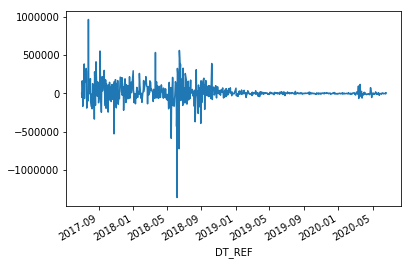

In [41]:
assets_base.groupby(by='DT_REF').sum()['Pnl'].plot()

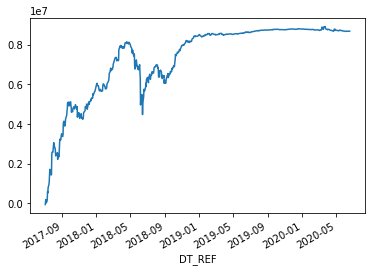

In [42]:
asset_data['pnl'].cumsum().plot()

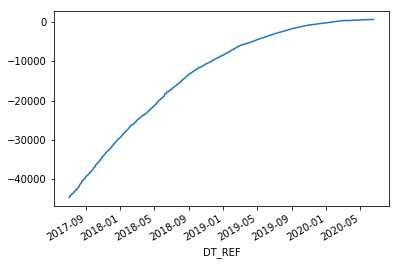

In [43]:
asset_data['DV'].plot()

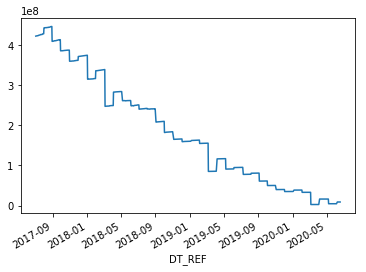

In [44]:
asset_data['saldo_mtm'].plot()

In [45]:
assets_base.tail()

,DU,Pre,ft_pre,dv_unit,DV,VF,VP,vcto,VP_d1,CDI,ft_cdi,ft_pre_d1,Pre_d1,Pnl
DT_REF,,,,,,,,,,,,,,
2020-06-18,1694,0.069040,1.566404,-0.000401,-0.474642,1182.791482,755.099704,2027-03-16,764.468340,2.9,1.000113,1.547208,0.067040,-9.455364
2020-06-18,1715,0.069386,1.578611,-0.000403,-0.282194,700.249460,443.585794,2027-04-15,449.157135,2.9,1.000113,1.559030,0.067385,-5.622297
2020-06-18,1736,0.069723,1.590913,-0.000405,-0.482564,1192.567925,749.612305,2027-05-17,759.141703,2.9,1.000113,1.570942,0.067723,-9.615522
2020-06-18,1757,0.070052,1.603311,-0.000406,-0.582026,1432.700158,893.588615,2027-06-16,905.084733,2.9,1.000113,1.582946,0.068052,-11.598799
2020-06-18,1778,0.070374,1.615805,-0.000408,-1.211754,2971.467579,1839.001356,2027-07-15,1862.941131,2.9,1.000113,1.595041,0.068374,-24.151123


In [46]:
asset_data.tail()

,saldo_mtm,saldo_open,DV,CDI,ft_cdi,pnl
DT_REF,,,,,,
2020-06-12,8.87942e+06,8.87902e+06,684.962,2.90,1.000113,398.395
2020-06-15,8.87994e+06,8.88043e+06,688.454,2.90,1.000113,-486.928
2020-06-16,8.88353e+06,8.88095e+06,690.987,2.90,1.000113,2576.67
2020-06-17,8.87942e+06,8.88453e+06,696.37,2.90,1.000113,-5116.65
2020-06-18,8.88903e+06,8.88042e+06,696.797,2.15,1.000084,8609.51


# Daily DV01 hedge

In [47]:
def dv_buckets(buckets, duration, dv) -> pd.DataFrame: 
    assert len(duration) == len(dv), 'Duration and dv should have same lenght. Check inputs.'
    _buckets = pd.Series(buckets)
    _duration = pd.Series(duration)
    _dv = pd.Series(dv)
#     _dv_df = pd.DataFrame(data=None, columns=['dur', 'dv'])
    result = pd.DataFrame(data=None, index=list(_buckets), columns=['dv'])
    _dv_lst = []
    for dur, dv in zip(_duration, _dv):
        dur_before = _buckets[_buckets < dur].max()
        dur_after = _buckets[_buckets >= dur].min()
        pct2 = (dur - dur_before) / (dur_after - dur_before)
        pct1 = 1.0 - pct2
        # Append data
        if np.isnan(dur_before):
            # puts all DV on the following bucket
            _dv_lst.append([dur_after, dv * 1.0])
        elif np.isnan(dur_after):
            # puts all DV on the previous bucket
            _dv_lst.append([dur_before, dv * 1.0])
        else:
            # break DVs by default
            _dv_lst.append([dur_before, dv * pct1])
            _dv_lst.append([dur_after, dv * pct2])
    _dv_df = pd.DataFrame(data=_dv_lst, columns=['dur', 'dv'])
    _dv_df = _dv_df.groupby(by='dur').sum()
    result.loc[_dv_df.index, 'dv'] = _dv_df['dv']
    return result

#### updating df_vertice

In [48]:
for dt in curve_dates[1:]:
    buckets = list(df_vertice.loc[dt,'BDAYS'])
    duration = list(assets_base.loc[dt, 'DU'])
    dv = list(assets_base.loc[dt, 'DV'])
    dv_tweaked = dv_buckets(buckets, duration, dv)
    df_vertice.loc[dt, 'DV_DI'] = dv_tweaked.loc[list(df_vertice.loc[dt, 'BDAYS']), 'dv'].values

In [49]:
# df_vertice['Lotes'] = df_vertice['DV_DI'] / df_vertice['DV_u'] * -1.0
df_vertice['Lotes'] = 0.0
df_vertice['Lotes_d1'] = 0.0
df_vertice['Pre'] = 0.0
df_vertice['ft_pre'] = 1.0
df_vertice['Pre_d1'] = 0.0
df_vertice['ft_pre_d1'] = 1.0
df_vertice['PU'] = 0.0
df_vertice['PU_d1_adj'] = 0.0
df_vertice['pnl'] = 0.0

In [50]:
df_vertice.loc[start_dt, 'Pre'], df_vertice.loc[start_dt, 'ft_pre'] = C.get_pre_tenor(start_dt, df_vertice.loc[start_dt, 'BDAYS'].values)

In [51]:
for dt, yest in zip(curve_dates[1:], curve_dates[:-1]):
    df_vertice.loc[dt, 'Pre'], df_vertice.loc[dt, 'ft_pre'] = C.get_pre_tenor(dt, df_vertice.loc[dt, 'BDAYS'].values)
    df_vertice.loc[dt, 'Pre_d1'], df_vertice.loc[dt, 'ft_pre_d1'] = C.get_pre_tenor(yest, df_vertice.loc[dt, 'BDAYS'].values + 1)
    cdi = C.cdi_selic.loc[yest, 'CDI']
    ft_cdi = (1.0 + cdi / 100.0) ** (1.0 / 252.0)
    PU = 100000.0 / df_vertice.loc[dt, 'ft_pre']
    PU_d1 = 100000.0 / df_vertice.loc[dt, 'ft_pre_d1'] * ft_cdi
    df_vertice.loc[dt, 'PU'] = PU.values
    df_vertice.loc[dt, 'PU_d1_adj'] = PU_d1.values

D:\Dropbox\FYY\Trading\Projects\Dados\Pre\Curva_Pre.py:650: RuntimeWarning: divide by zero encountered in true_divide
  rate = factor ** (252.0 / n_bdays) - 1.0


In [52]:
df_vertice['DV_u'] = 100000.0 / (1.0 + df_vertice['Pre']) ** (df_vertice['BDAYS'] / 252) - 100000.0 / (1.0001 + df_vertice['Pre']) ** (df_vertice['BDAYS'] / 252)

In [54]:
df_vertice.loc[start_dt, 'Lotes'] = divide_robust(df_vertice.loc[start_dt, 'DV_DI'], df_vertice.loc[start_dt, 'DV_u']) * -1.0

In [55]:
for dt, yest in zip(curve_dates[1:], curve_dates[:-1]):
    df_vertice.loc[dt, 'Lotes'] = divide_robust(df_vertice.loc[dt, 'DV_DI'], df_vertice.loc[dt, 'DV_u']) * -1.0
    if len(df_vertice.loc[yest].index) < len(df_vertice.loc[dt].index):
        idx = df_vertice.loc[yest].index
    else:
        idx = df_vertice.loc[dt].index
    df_vertice.loc[(dt, idx), 'Lotes_d1'] = df_vertice.loc[(yest, idx), 'Lotes'].values
    df_vertice.loc[curve_dates[1], 'Lotes_d1'] = df_vertice.loc[(curve_dates[0], df_vertice.loc[curve_dates[1]].index), 'Lotes'].values

In [56]:
df_vertice['pnl'] = (df_vertice['PU'] - df_vertice['PU_d1_adj']) * df_vertice['Lotes_d1']

In [57]:
df_vertice.pnl.fillna(value=0.0, inplace=True)

In [58]:
df_vertice

BDAYS  TRADING_VOLUME  SETTLE_RATE       DV_u  \
DT_REF     DT_EXPIRY_BUS                                                  
2017-07-03 2018-01-02       125          135155        8.840   4.369611   
           2018-07-02       249           89760        8.645   8.378538   
           2019-01-02       375          163260        8.810  12.059953   
           2020-01-02       628          102160        9.430  18.189594   
           2021-01-04       879          118540        9.980  22.755156   
           2023-01-02      1381           34545       10.440  28.787228   
           2025-01-02      1884           32720       10.670  31.645220   
2017-07-04 2018-01-02       124          135155        8.840   4.336410   
           2018-07-02       248           89760        8.645   8.349925   
           2019-01-02       374          163260        8.810  12.034573   
           2020-01-02       627          102160        9.430  18.161340   
           2021-01-04       878          118540        9.980  22.719323   
           2023-01-02      1380           34545       10.440  28.659882   
           2025-01-02      1883           32720       10.670  31.472115   
2017-07-05 2018-01-02       123          135155        8.840   4.304357   
           2018-07-02       247           89760        8.645   8.326577   
           2019-01-02       373          163260        8.810  12.017369   
           2020-01-02       626          102160        9.430  18.150423   
           2021-01-04       877          118540        9.980  22.720536   
           2023-01-02      1379           34545       10.440  28.667267   
           2025-01-02      1882           32720       10.670  31.516308   
           2027-01-04      2385           24210       10.840  32.222985   
2017-07-06 2018-01-02       122          135155        8.840   4.271376   
           2018-07-02       246           89760        8.645   8.295575   
           2019-01-02       372          163260        8.810  11.994606   
           2020-01-02       625          102160        9.430  18.156762   
           2021-01-04       876          118540        9.980  22.721691   
           2023-01-02      1378           34545       10.440  28.708210   
           2025-01-02      1881           32720       10.670  31.560520   
           2027-01-04      2384           24210       10.840  32.253055   
...                         ...             ...          ...        ...   
2020-06-15 2023-01-02       642           34545       10.440  22.050182   
           2024-01-02       891           17095        8.540  28.234142   
           2025-01-02      1145           32720       10.670  33.388737   
           2027-01-04      1648           24210       10.840  40.261895   
           2029-01-02      2148           15315       10.610  43.863159   
           2031-01-02      2651           15680        7.170  45.460020   
2020-06-16 2021-01-04       139          118540        9.980   5.340440   
           2022-01-03       390           20400        9.340  14.323429   
           2023-01-02       641           34545       10.440  21.989450   
           2024-01-02       890           17095        8.540  28.147260   
           2025-01-02      1144           32720       10.670  33.262217   
           2027-01-04      1647           24210       10.840  39.964471   
           2029-01-02      2147           15315       10.610  43.351918   
           2031-01-02      2650           15680        7.170  44.804107   
2020-06-17 2021-01-04       138          118540        9.980   5.302859   
           2022-01-03       389           20400        9.340  14.299009   
           2023-01-02       640           34545       10.440  22.011026   
           2024-01-02       889           17095        8.540  28.218314   
           2025-01-02      1143           32720       10.670  33.432562   
           2027-01-04      1646           24210       10.840  40.290446   
           2029-01-02      2146           15315    

In [59]:
df_vertice.groupby(by=['DT_REF']).sum()

,BDAYS,TRADING_VOLUME,SETTLE_RATE,DV_u,DV_traded,M,Lotes,Lotes_d1,Pre,ft_pre,Pre_d1,ft_pre_d1,PU,PU_d1_adj,pnl
DT_REF,,,,,,,,,,,,,,,
2017-07-03,5521,676140,66.815,126.185299,9.897072e+06,13.0,4309.101141,0.000000,0.66815,9.764580,0.00000,7.000000,0.00,0.000000,0.000000
2017-07-04,5514,676140,66.815,125.733570,0.000000e+00,13.0,4491.633289,4309.101141,0.66955,9.777912,0.66815,9.764580,532483.49,532957.163246,361.314325
2017-07-05,7892,700350,77.655,157.925822,7.801184e+05,14.0,4490.905649,4491.633289,0.77610,12.416509,0.77825,12.434418,570702.39,570345.470029,127991.154625
2017-07-06,7884,700350,77.655,157.961795,0.000000e+00,14.0,4489.352110,4490.905649,0.77450,12.401476,0.77610,12.416509,571252.88,570921.160627,89806.676083
2017-07-07,7876,700350,77.655,157.110564,0.000000e+00,14.0,4488.261135,4489.352110,0.77870,12.440288,0.77450,12.401476,570373.39,571471.861650,-183056.260721
2017-07-10,7868,700350,77.655,157.676433,0.000000e+00,14.0,4486.995113,4488.261135,0.77495,12.390241,0.77870,12.440288,571589.19,570592.034510,67747.044810
2017-07-11,7860,700350,77.655,157.638971,0.000000e+00,14.0,4485.793998,4486.995113,0.77340,12.379705,0.77495,12.390241,572043.22,571808.300569,92407.914988
2017-07-12,7852,700350,77.655,159.351120,0.000000e+00,14.0,4483.616784,4485.793998,0.76140,12.263234,0.77340,12.379705,575171.06,572262.504615,425277.814431
2017-07-13,7844,700350,77.655,158.844226,0.000000e+00,14.0,4482.293717,4483.616784,0.76350,12.279313,0.76140,12.263234,574801.93,575391.543628,-80693.540174


In [60]:
# s_pnl_hedge = df_vertice.groupby(by=['DT_REF']).sum()['pnl']

In [61]:
s_pnl_hedge = df_vertice.pnl.groupby(by='DT_REF').sum()

In [62]:
df_vertice.tail()

BDAYS  TRADING_VOLUME  SETTLE_RATE       DV_u  \
DT_REF     DT_EXPIRY_BUS                                                  
2020-06-18 2024-01-02       888           17095         8.54  28.022751   
           2025-01-02      1142           32720        10.67  33.062949   
           2027-01-04      1645           24210        10.84  39.712038   
           2029-01-02      2145           15315        10.61  43.182654   
           2031-01-02      2648           15680         7.17  44.581766   

                          DV_traded    M    DV_DI     Lotes  Lotes_d1     Pre  \
DT_REF     DT_EXPIRY_BUS                                                        
2020-06-18 2024-01-02           0.0  1.0   79.517 -2.837586 -2.838169  0.0519   
           2025-01-02           0.0  1.0  79.8531 -2.415182 -2.414180  0.0586   
           2027-01-04           0.0  1.0  21.9531 -0.552807 -0.551785  0.0682   
           2029-01-02           0.0  1.0 -0.61763  0.014303  0.014264  0.0739   
           2031-01-02           0.0  1.0      NaN       NaN       NaN  0.0773   

                            ft_pre  Pre_d1  ft_pre_d1        PU     PU_d1_adj  \
DT_REF     DT_EXPIRY_BUS                                                        
2020-06-18 2024-01-02     1.195181  0.0505   1.189818  83669.31  84056.004965   
           2025-01-02     1.294430  0.0566   1.283665  77254.07  77910.787877   
           2027-01-04     1.538288  0.0662   1.519971  65007.34  65798.213877   
           2029-01-02     1.834684  0.0719   1.806300  54505.30  55368.060723   
           2031-01-02     2.186712  0.0753   2.145046  45730.76  46624.328871   

                                  pnl  
DT_REF     DT_EXPIRY_BUS               
2020-06-18 2024-01-02     1097.505545  
           2025-01-02     1585.435224  
           2027-01-04      436.392581  
           2029-01-02      -12.306753  
           2031-01-02        0.000000

In [63]:
df_vertice

BDAYS  TRADING_VOLUME  SETTLE_RATE       DV_u  \
DT_REF     DT_EXPIRY_BUS                                                  
2017-07-03 2018-01-02       125          135155        8.840   4.369611   
           2018-07-02       249           89760        8.645   8.378538   
           2019-01-02       375          163260        8.810  12.059953   
           2020-01-02       628          102160        9.430  18.189594   
           2021-01-04       879          118540        9.980  22.755156   
           2023-01-02      1381           34545       10.440  28.787228   
           2025-01-02      1884           32720       10.670  31.645220   
2017-07-04 2018-01-02       124          135155        8.840   4.336410   
           2018-07-02       248           89760        8.645   8.349925   
           2019-01-02       374          163260        8.810  12.034573   
           2020-01-02       627          102160        9.430  18.161340   
           2021-01-04       878          118540        9.980  22.719323   
           2023-01-02      1380           34545       10.440  28.659882   
           2025-01-02      1883           32720       10.670  31.472115   
2017-07-05 2018-01-02       123          135155        8.840   4.304357   
           2018-07-02       247           89760        8.645   8.326577   
           2019-01-02       373          163260        8.810  12.017369   
           2020-01-02       626          102160        9.430  18.150423   
           2021-01-04       877          118540        9.980  22.720536   
           2023-01-02      1379           34545       10.440  28.667267   
           2025-01-02      1882           32720       10.670  31.516308   
           2027-01-04      2385           24210       10.840  32.222985   
2017-07-06 2018-01-02       122          135155        8.840   4.271376   
           2018-07-02       246           89760        8.645   8.295575   
           2019-01-02       372          163260        8.810  11.994606   
           2020-01-02       625          102160        9.430  18.156762   
           2021-01-04       876          118540        9.980  22.721691   
           2023-01-02      1378           34545       10.440  28.708210   
           2025-01-02      1881           32720       10.670  31.560520   
           2027-01-04      2384           24210       10.840  32.253055   
...                         ...             ...          ...        ...   
2020-06-15 2023-01-02       642           34545       10.440  22.050182   
           2024-01-02       891           17095        8.540  28.234142   
           2025-01-02      1145           32720       10.670  33.388737   
           2027-01-04      1648           24210       10.840  40.261895   
           2029-01-02      2148           15315       10.610  43.863159   
           2031-01-02      2651           15680        7.170  45.460020   
2020-06-16 2021-01-04       139          118540        9.980   5.340440   
           2022-01-03       390           20400        9.340  14.323429   
           2023-01-02       641           34545       10.440  21.989450   
           2024-01-02       890           17095        8.540  28.147260   
           2025-01-02      1144           32720       10.670  33.262217   
           2027-01-04      1647           24210       10.840  39.964471   
           2029-01-02      2147           15315       10.610  43.351918   
           2031-01-02      2650           15680        7.170  44.804107   
2020-06-17 2021-01-04       138          118540        9.980   5.302859   
           2022-01-03       389           20400        9.340  14.299009   
           2023-01-02       640           34545       10.440  22.011026   
           2024-01-02       889           17095        8.540  28.218314   
           2025-01-02      1143           32720       10.670  33.432562   
           2027-01-04      1646           24210       10.840  40.290446   
           2029-01-02      2146           15315    

### Testing function

#### Inputs

In [ ]:
buckets = df_vertice.loc[start_dt, 'BDAYS']
duration = assets_base.loc[start_dt, 'DU']
dv = assets_base.loc[start_dt, 'DV']

In [ ]:
_buckets = pd.Series(buckets)
_duration = pd.Series(duration)
_dv = pd.Series(dv)
# _dv_df = pd.DataFrame(data=None, columns=['dur', 'dv'])
result = pd.DataFrame(data=None, index=list(_buckets), columns=['dv'])
_dv_lst = []

In [ ]:
for dur, dv in zip(_duration, _dv):
    dur_before = _buckets[_buckets < dur].max()
    dur_after = _buckets[_buckets >= dur].min()
    pct2 = (dur - dur_before) / (dur_after - dur_before)
    pct1 = 1.0 - pct2
    # Append data
    if np.isnan(dur_before):
        # puts all DV on the following bucket
        _dv_lst.append([dur_after, dv * 1.0])
    elif np.isnan(dur_after):
        # puts all DV on the previous bucket
        _dv_lst.append([dur_before, dv * 1.0])
    else:
        # break DVs by default
        _dv_lst.append([dur_before, dv * pct1])
        _dv_lst.append([dur_after, dv * pct2])

In [ ]:
_dv_df = pd.DataFrame(data=_dv_lst, columns=['dur', 'dv'])
_dv_df = _dv_df.groupby(by='dur').sum()
result.loc[_dv_df.index, 'dv'] = _dv_df['dv']
result

# Test area

# Result analysis

In [64]:
df_carteira = pd.DataFrame(data=0.0, index=curve_dates, columns=['Ativos', 'Hedge', 'Carteira'])

In [65]:
s_pnl_ativos = assets_base.groupby(by='DT_REF').sum()['Pnl']

In [66]:
df_carteira.loc[s_pnl_hedge.index, 'Hedge'] = s_pnl_hedge

In [67]:
df_carteira.loc[s_pnl_ativos.index, 'Ativos'] = s_pnl_ativos

In [68]:
df_carteira['Carteira'] = df_carteira.Ativos - df_carteira.Hedge

In [96]:
s_dv_ativos = assets_base.groupby(by='DT_REF').sum()['DV']
df_carteira['dv'] = 0.0
df_carteira.loc[s_dv_ativos.index, 'dv'] = s_dv_ativos.values

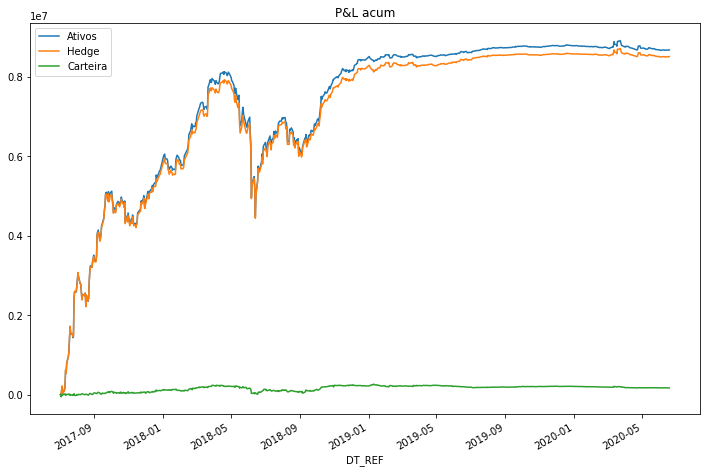

In [154]:
df_carteira[['Ativos', 'Hedge', 'Carteira']].cumsum().plot(figsize=(12,8), title='P&L acum')

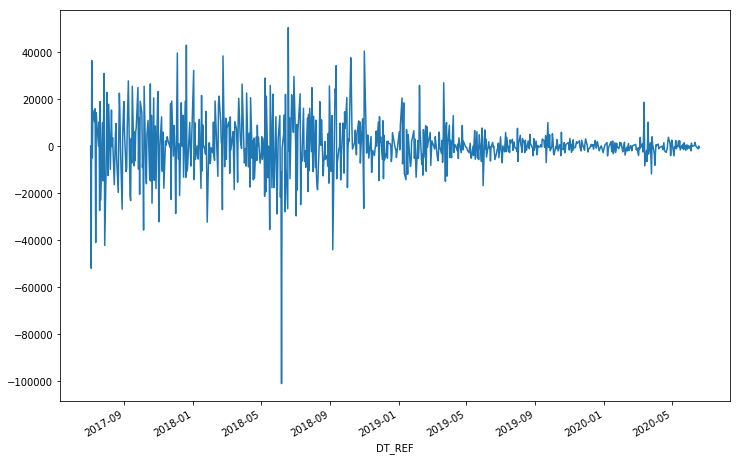

In [70]:
(df_carteira['Ativos'] - df_carteira['Hedge']).plot(figsize=(12,8))

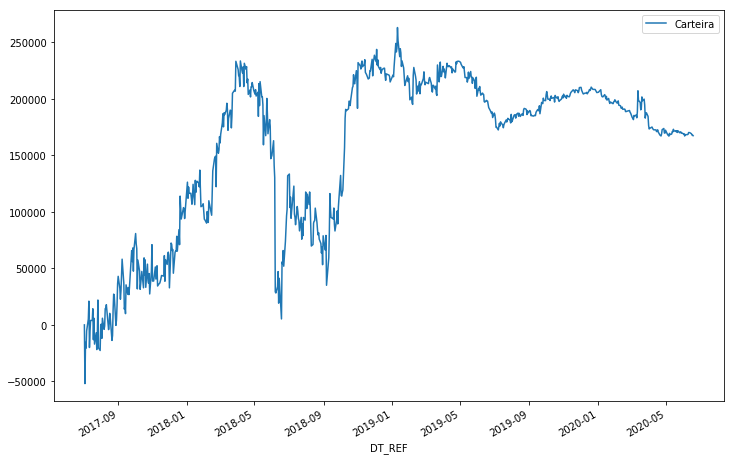

In [124]:
df_carteira.Carteira.cumsum().plot(figsize=(12,8), legend=True)

In [107]:
s_pnl_acum = df_carteira.Carteira.cumsum()

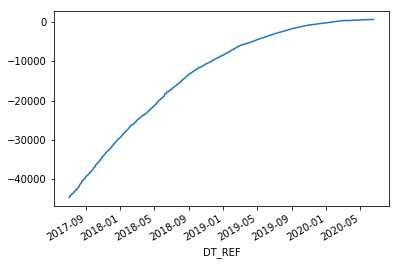

In [113]:
df_carteira['dv'].plot()

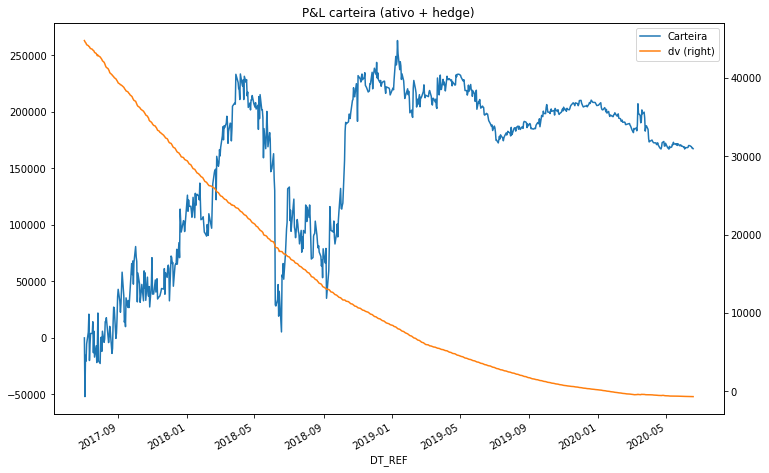

In [157]:
s_pnl_acum.plot(figsize=(12,8), legend=True, title='P&L carteira (ativo + hedge)')
df_carteira['dv'].multiply(-1).plot(secondary_y=True, figsize=(12,8), legend=True)

In [126]:
df_carteira.Carteira.std()

11841.134511777598

In [127]:
df_carteira.dv.mean()

-13304.294710670027

In [128]:
df_carteira.Carteira.std() / df_carteira.dv.mean()

-0.8900234675560084

In [132]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

def newline(p1, p2):
    ax = plt.gca()
    xmin, xmax = ax.get_xbound()

    if(p2[0] == p1[0]):
        xmin = xmax = p1[0]
        ymin, ymax = ax.get_ybound()
    else:
        ymax = p1[1]+(p2[1]-p1[1])/(p2[0]-p1[0])*(xmax-p1[0])
        ymin = p1[1]+(p2[1]-p1[1])/(p2[0]-p1[0])*(xmin-p1[0])

    l = mlines.Line2D([xmin,xmax], [ymin,ymax])
    ax.add_line(l)
    return l

In [143]:
df_carteira['Hedge'].min()

-1255264.9837839915

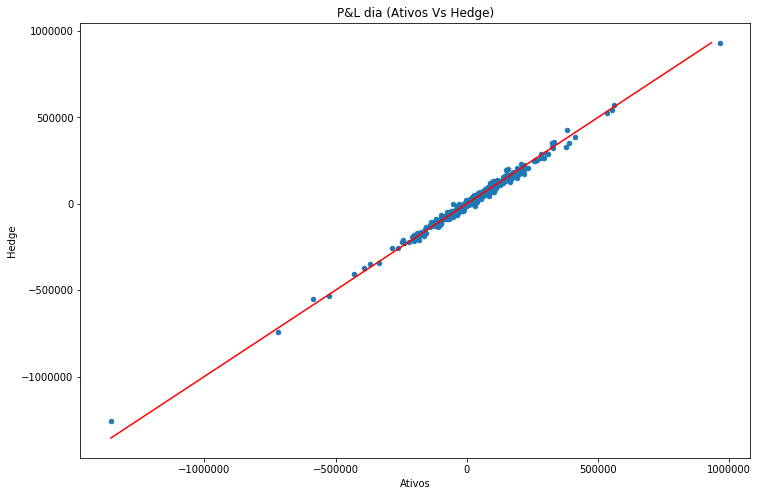

In [158]:
df_carteira.plot.scatter(x='Ativos', y='Hedge', figsize=(12,8), title='P&L dia (Ativos Vs Hedge)')
x = np.linspace(df_carteira['Ativos'].min(),df_carteira['Hedge'].max())
y = x*1
plt.plot(x, y, color='red')
plt.show()

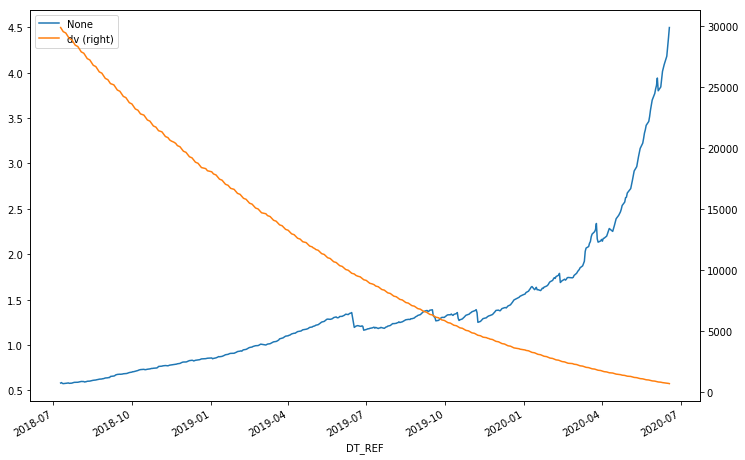

In [172]:
(df_carteira.Carteira.rolling(252).std() / df_carteira.dv.multiply(-1).rolling(252).mean()).plot(figsize=(12,8), legend='vol')
df_carteira.dv.multiply(-1).rolling(252).mean().plot(secondary_y=True, legend='dv')

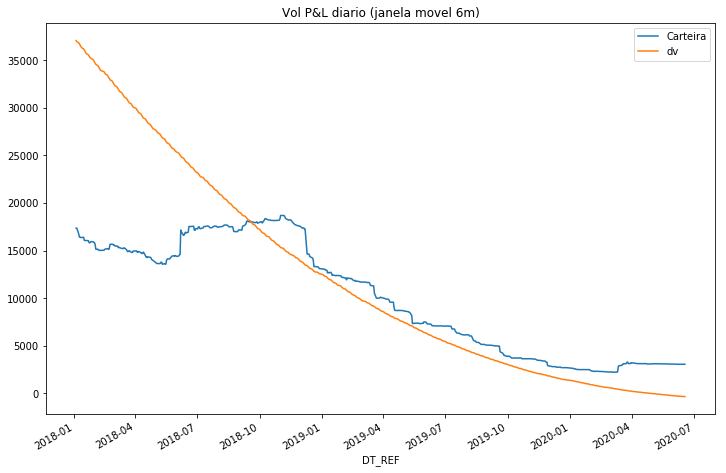

In [176]:
df_carteira.Carteira.rolling(126).std().plot(figsize=(12,8), legend=True, title='Vol P&L diario (janela movel 6m)')
df_carteira.dv.multiply(-1).rolling(126).mean().plot(secondary_y=False, legend='dv')

In [177]:
assets_base.to_excel(r'D:\Dropbox\FYY\Trading\Projects\Dados\Pre\TESTE\assets_base.xlsx')
df_vertice.to_excel(r'D:\Dropbox\FYY\Trading\Projects\Dados\Pre\TESTE\df_vertice.xlsx')
df_carteira.to_excel(r'D:\Dropbox\FYY\Trading\Projects\Dados\Pre\TESTE\df_carteira.xlsx')

In [180]:
assets_base.loc[start_dt].VP.sum()

421852815.06633794

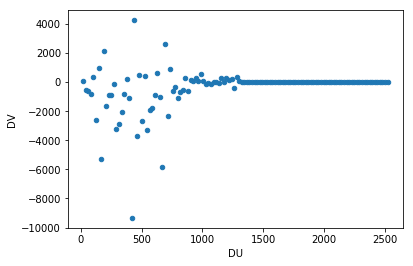

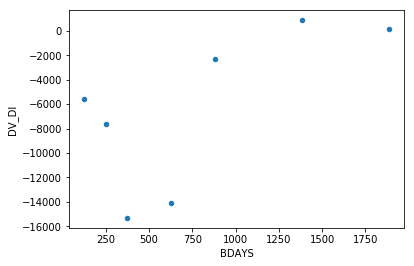

In [209]:
assets_base.loc[start_dt][['DU', 'DV']].plot.scatter(x='DU', y='DV')
df_vertice.loc[start_dt][['BDAYS', 'DV_DI']].astype(np.float64).plot.scatter(x='BDAYS', y='DV_DI')

In [206]:
df_vertice.loc[start_dt][['BDAYS', 'DV_DI']].astype(np.float64)

,BDAYS,DV_DI
DT_EXPIRY_BUS,,
2018-01-02,125.0,-5616.663866
2018-07-02,249.0,-7650.556172
2019-01-02,375.0,-15308.498421
2020-01-02,628.0,-14069.895288
2021-01-04,879.0,-2317.666043
2023-01-02,1381.0,857.093379
2025-01-02,1884.0,138.076305


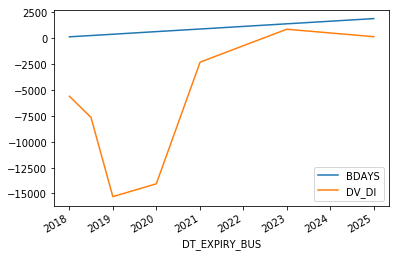

In [198]:
df_vertice.loc[start_dt, ['BDAYS', 'DV_DI']].reset_index().plot()